<a href="https://colab.research.google.com/github/renatarep-ad/AD_diabetes_hipertensao/blob/main/AD_diabetes_hipertens%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#####Importações

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import warnings
import plotly.express as px
warnings.filterwarnings("ignore")

- Base de dados: [Kaggle - diabetes_prediction_dataset.csv](https://www.kaggle.com/)

- Total de registros: 100 mil.

##### 1. Leitura dos dados

In [ ]:
df = pd.read_csv('/content/diabetes_prediction_dataset.csv')
df.head(2)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0


##### 2. Renomear colunas

In [ ]:
df.columns
['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']

df = df.rename(columns={'gender': 'Gênero', 'age': 'Idade', 'hypertension': 'Hipertensão', 'heart_disease': 'Doença cardíaca',
                        'smoking_history': 'Histórico de tabagismo','bmi':'IMC', 'HbA1c_level':'Nível de hemoglobina', 'blood_glucose_level': 'Nível de glicose no sangue', 'diabetes': 'Diabetes'})

df.head()

,Gênero,Idade,Hipertensão,Doença cardíaca,Histórico de tabagismo,IMC,Nível de hemoglobina,Nível de glicose no sangue,Diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


##### 3. Renomear valores da coluna *Histórico de tabagismo*

In [ ]:
df['Gênero'] = df['Gênero'].apply(lambda x: x.replace('Female', 'Feminino').replace('Male', 'Masculino'))

#df['Histórico de tabagismo'].unique()
df['Histórico de tabagismo']= df['Histórico de tabagismo'].apply(lambda x: x.replace('never','sem histórico').replace('No Info', 'sem informação').replace('current','histórico atual').replace('former', 'histórico antigo').replace('ever','sempre').replace('not histórico atual','sem histórico atual'))
df.tail(10)

,Gênero,Idade,Hipertensão,Doença cardíaca,Histórico de tabagismo,IMC,Nível de hemoglobina,Nível de glicose no sangue,Diabetes
99990,Masculino,39.0,0,0,sem informação,27.32,6.1,100,0
99991,Masculino,22.0,0,0,histórico atual,29.65,6.0,80,0
99992,Feminino,26.0,0,0,sem histórico,34.34,6.5,160,0
99993,Feminino,40.0,0,0,sem histórico,40.69,3.5,155,0
99994,Feminino,36.0,0,0,sem informação,24.60,4.8,145,0
99995,Feminino,80.0,0,0,sem informação,27.32,6.2,90,0
99996,Feminino,2.0,0,0,sem informação,17.37,6.5,100,0
99997,Masculino,66.0,0,0,histórico antigo,27.83,5.7,155,0
99998,Feminino,24.0,0,0,sem histórico,35.42,4.0,100,0
99999,Feminino,57.0,0,0,histórico atual,22.43,6.6,90,0


##### 4. Identificar informações básicas, valores duplicados e ausentes

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Gênero                      100000 non-null  object 
 1   Idade                       100000 non-null  float64
 2   Hipertensão                 100000 non-null  int64  
 3   Doença cardíaca             100000 non-null  int64  
 4   Histórico de tabagismo      100000 non-null  object 
 5   IMC                         100000 non-null  float64
 6   Nível de hemoglobina        100000 non-null  float64
 7   Nível de glicose no sangue  100000 non-null  int64  
 8   Diabetes                    100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [ ]:
df.isnull().sum()

Gênero                        0
Idade                         0
Hipertensão                   0
Doença cardíaca               0
Histórico de tabagismo        0
IMC                           0
Nível de hemoglobina          0
Nível de glicose no sangue    0
Diabetes                      0
dtype: int64

In [ ]:
#Identificar dados duplicados
duplicados=df.duplicated()
print(f'Total de dados duplicados:{duplicados.sum()}')

#Limpar dados duplicados
df = df.drop_duplicates()
print(f'Total de dados duplicados:{duplicados.sum()}')

Total de dados duplicados:3854
Total de dados duplicados:3854


##### 4. Estatística descritiva
##### *A estatística ou análise descritiva ocorre a partir da descrição do dataframe e inclui a análise de tendência central, dispersão dos valores e a distribuição dos valores em percentis.*
- Count: retorna o número de registros N/A para as colunas.
- Mean: retorna a média aritmética dos valores/total de registros(count), por exemplo, a média de idade do público está em 41 a 42 anos.
- STD: corresponde ao desvio padrão em relação a média, o quanto os dados estão distribuidos em um valor, por exemplo, 22 mil pessoas estão dispersando da média.
- Min e Max: são valores que auxiliam na amplitude da amostra, a idade mínima identifica foi 0.08 (36 registros) e a idade máxima foi 80 (5.621 registros, considerado o valor mais comum (.mode())).
- Quartis: são os valores que apresentam a distribuição dos dados em 3 períodos, 25, 50 (mediano - .median()) e 75%, por exemplo, metade do público está na faixa etária de 43 anos.


In [ ]:
df.describe()

,Idade,Hipertensão,Doença cardíaca,IMC,Nível de hemoglobina,Nível de glicose no sangue,Diabetes
count,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000
mean,41.794326,0.077601,0.040803,27.321461,5.532609,138.218231,0.088220
std,22.462948,0.267544,0.197833,6.767716,1.073232,40.909771,0.283616
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.000000,0.000000,23.400000,4.800000,100.000000,0.000000
50%,43.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,59.000000,0.000000,0.000000,29.860000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000


<Axes: xlabel='Gênero', ylabel='Idade'>

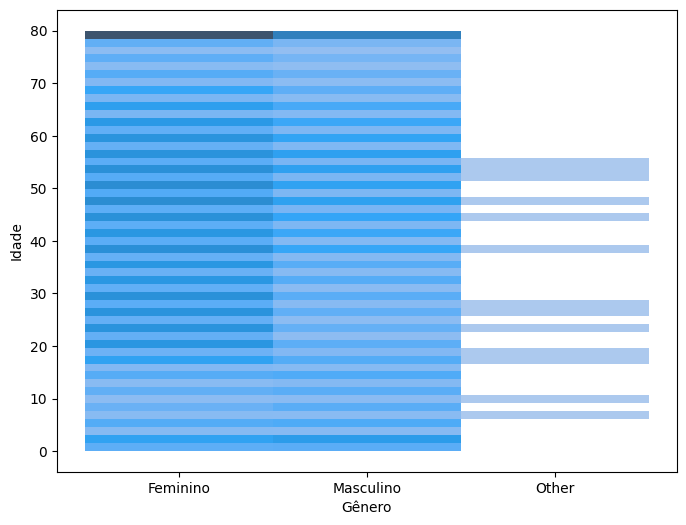

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(data=df,x='Gênero', y= 'Idade')

#####*4.1 Os valores mais registrados*
##### A partir da moda podemos identificar quais foram os valores mais frequentes por colunas, é uma análise de tendencia central para cada categoria.
- Por exemplo: para a base de dados com 100.000 entradas, o gênero principal foi o feminino (58.552 registros, consideramos que além de Feminino e Masculino, a base de dados possui registro de gênero para Outros (18 registros)), a idade mais acessada foi 80 anos, a maioria dos entrevistados não apresentaram informação para histórico de tabagismo, a média de IMC foi 27 (Entre 25,0 e 29,9 =	Sobrepeso) e a taxa de glicose foi 130 (>= 126 mg/dL = Diabetes).

In [ ]:
df.mode()

,Gênero,Idade,Hipertensão,Doença cardíaca,Histórico de tabagismo,IMC,Nível de hemoglobina,Nível de glicose no sangue,Diabetes
0,Feminino,80.0,0,0,sem histórico,27.32,6.6,159,0


In [ ]:
# Quantidade de entrevistados por idade
df['Idade'].sort_values().value_counts()

Idade
80.00    4932
51.00    1566
47.00    1511
48.00    1508
53.00    1498
         ... 
0.48       83
1.00       83
0.40       66
0.16       59
0.08       36
Name: count, Length: 102, dtype: int64

#####Gráfico e análise Idade x Diabetes


Idade mínimo e máxima dos pacientes com ou sem predisposição para desenvolver diabetes
0 = Pacientes sem predisposição para desenvolver diabetes
1 = Pacientes com predisposição para desenvolver diabetes
           min   max
Diabetes            
0         0.08  80.0
1         3.00  80.0
 
- A idade mínima para desenvolver / com predisposição para diabetes é 3 anos e a máxima 80 anos.
- A idade mínima para não desenvolver diabetes é 0.8 anos e a máxima 80 anos.
 


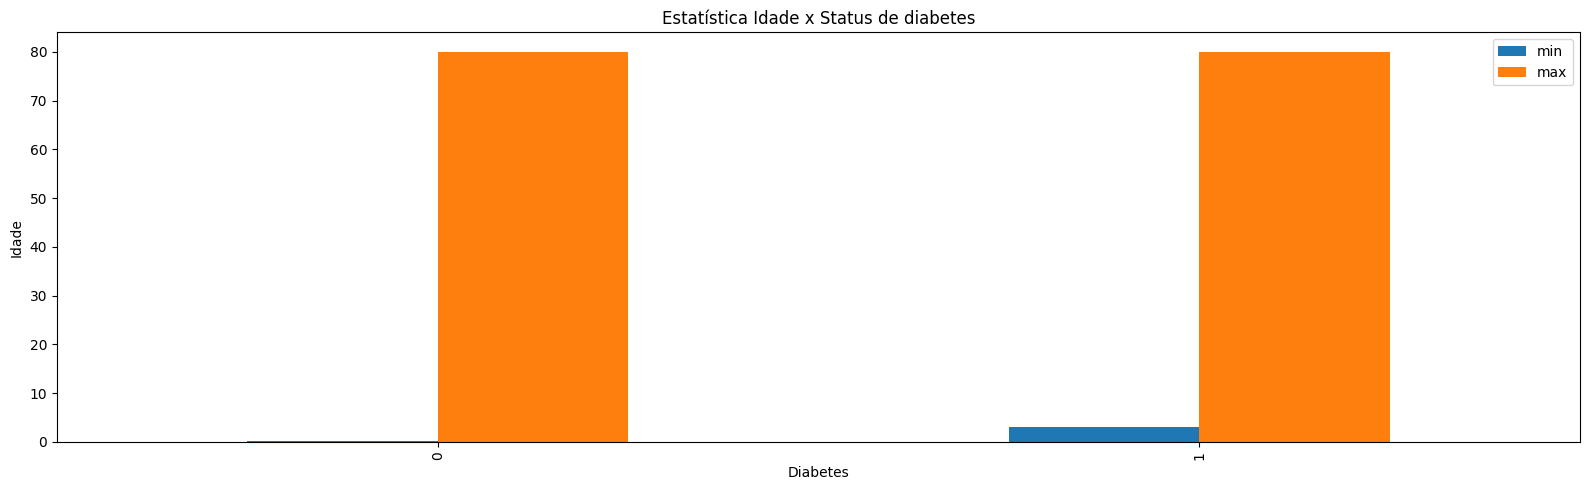

In [ ]:
diabetes_total = df['Diabetes'].value_counts()

#Idades
idade_min= df['Idade'].min()
idade_media= df['Idade'].mean()
idade_max= df['Idade'].max()

#Agrupar por status de diabetes com as idades
idade_grupo = df.groupby('Diabetes')['Idade'].agg(['min', 'max'])
print('Idade mínimo e máxima dos pacientes com ou sem predisposição para desenvolver diabetes\n0 = Pacientes sem predisposição para desenvolver diabetes\n1 = Pacientes com predisposição para desenvolver diabetes')
print(idade_grupo)

print(' ')
print('- A idade mínima para desenvolver / com predisposição para diabetes é 3 anos e a máxima 80 anos.\n- A idade mínima para não desenvolver diabetes é 0.8 anos e a máxima 80 anos.')
print(' ')


#Gráfico idade x status diabetes
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
grupo_diabetes_idade = idade_grupo.plot(kind='bar',ax=ax)
ax.set_title('Estatística Idade x Status de diabetes')
ax.set_ylabel('Idade')
plt.tight_layout()
plt.show()

In [ ]:
#Proporção de pacientes com predisposição para Diabetes
print(df['Diabetes'].value_counts(normalize=True))

print('\nResultado:')
print('91,17% dos pacientes sem predisposição para desenvolver diabetes\n8.9% dos pacientes com predisposição para desenvolver diabetes')

Diabetes
0    0.91178
1    0.08822
Name: proportion, dtype: float64

Resultado:
91,17% dos pacientes sem predisposição para desenvolver diabetes
8.9% dos pacientes com predisposição para desenvolver diabetes


#####Gráfico e análise Histórico de tabagismo x Diabetes


Resultado:
- No grupo que não apresenta predisposição para desenvolver diabeter (0):
1. mais de 30 mil registros não possuem histórico de tabagismo


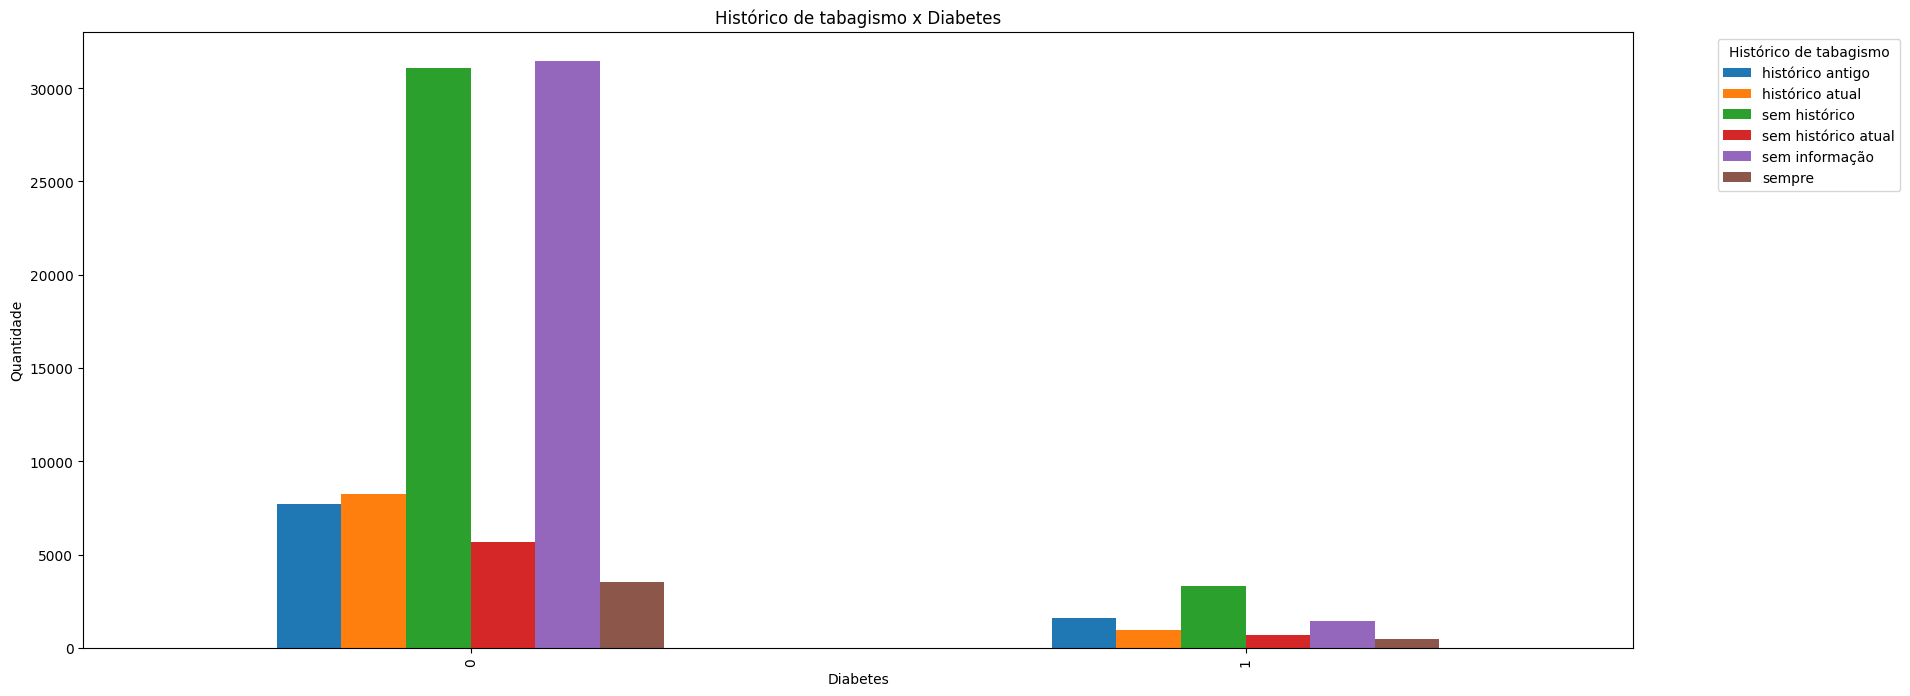

In [ ]:
cross_table = pd.crosstab(df['Diabetes'], df['Histórico de tabagismo'])

# graficos
fig, ax = plt.subplots(figsize=(20, 8))

# Plotting the cross table with separate bars for smoking history
cross_table.plot(kind='bar', stacked=False, ax=ax)
ax.set_title('Histórico de tabagismo x Diabetes')
ax.set_xlabel('Diabetes')
ax.set_ylabel('Quantidade')
ax.legend(title='Histórico de tabagismo', bbox_to_anchor=(1.05, 1), loc='upper left')

print('Resultado:')
print('- No grupo que não apresenta predisposição para desenvolver diabetes (0):\n1. mais de 30 mil registros não possuem histórico de tabagismo' )

In [ ]:
df['Histórico de tabagismo'].unique()

array(['sem histórico', 'sem informação', 'histórico atual',
       'histórico antigo', 'sempre', 'sem histórico atual'], dtype=object)

In [ ]:
df.head()
df['Doença cardíaca'].value_counts()
d = df.groupby(['Doença cardíaca']).size().rename("total").reset_index()
d.head()


,Doença cardíaca,total
0,0,92223
1,1,3923


In [ ]:
px.bar(df,x=df['Doença cardíaca'],y=df['Gênero'],color=df['Histórico de tabagismo'])

In [116]:
#Em desenvolvimento